In [1]:
# Necessary imports
%load_ext autoreload
%autoreload 2\

import networkx as nx
import numpy as np
import pandas as pd
import scipy.sparse as sps

from TCGAMultiOmics.multiomics import MultiOmicsData
from moge.visualization.plot_data import matrix_heatmap, plot_coo_matrix

import seaborn
import matplotlib.pyplot as plt

# Import the TCGA cancer data

In [2]:
folder_path = "/home/jonny/PycharmProjects/Bioinformatics_ExternalData/tcga-assembler/LUAD/"
external_data_path = "/home/jonny/PycharmProjects/Bioinformatics_ExternalData/"
luad_data = MultiOmicsData(cancer_type="LUAD", tcga_data_path=folder_path, external_data_path=external_data_path,
                           modalities=[\
                                       "GE",
                                       "MIR",
                                       "LNC",
                                       # "CNV",
                                       # "SNP",
#                                        "PRO",
                                       # "DNA"
                                       ])

/home/jonny/.conda/envs/jonny_conda3/lib/python3.6/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


PATIENTS (522, 110)
DRUGS (461, 4)
GE (576, 20284)
MIR (494, 1870)
LNC (546, 12727)
SAMPLES (599, 111)
Processed genes info for  GE
Processed genes info for  MIR


/home/jonny/.conda/envs/jonny_conda3/lib/python3.6/site-packages/TCGAMultiOmics/genomic.py:615: FutureWarning: 'MiRBase ID' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  self.gene_info = self.gene_info.join(self.targetScan_family_df.groupby("MiRBase ID").first(), on="MiRBase ID",how="left")
/home/jonny/.conda/envs/jonny_conda3/lib/python3.6/site-packages/TCGAMultiOmics/genomic.py:309: FutureWarning: 'symbol' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  self.gene_info = self.gene_info.join(self.HGNC_lncrna_info.groupby("symbol").first(), on="symbol",
/home/jonny/.conda/envs/jonny_conda3/lib/python3.6/site-packages/pandas/core/frame.py:6336: FutureWarning: 'Gene Name' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  rsuffix=rsuffix, sort=sort)


Processed genes info for  LNC


# Heterogeneous Network

In [3]:
from moge.network.heterogeneous_network import HeterogeneousNetwork

network = HeterogeneousNetwork(modalities=["MIR", "GE", "LNC"], multi_omics_data=luad_data)

MIR  nodes: 1870
GE  nodes: 20284
LNC  nodes: 12725
Total nodes: 34879


## Write node labels to file

In [7]:
# READ Edgeslist
network.import_edgelist_file(file="lncRNA-miRNA-mRNA_new-08-14.edgelist", 
                             is_directed=True)

In [16]:
# WRITE Edgelist
nx.write_edgelist(network_train.get_subgraph(["MIR", "GE", "LNC"]), 
                  "moge/data/lncRNA_miRNA_mRNA/lmn_network_filtered_directed.edgelist", 
                  data=False)

In [4]:
from moge.network.file_io import write_node_labels_to_file

# write_node_labels_to_file("moge/data/lncRNA_miRNA_mRNA/lncRNA-miRNA-mRNA_node_labels_family.tsv", luad_data, 
#                           label_cols=["family"],
#                           modalities=["MIR", "GE", "LNC"], 
#                           get_dummies=False)

# write_node_labels_to_file("moge/data/lncRNA_miRNA_mRNA/lncRNA-miRNA-mRNA_node_labels_disease_dummies.tsv", luad_data, 
#                           label_cols=["Disease association"],
#                           modalities=["MIR", "GE", "LNC"], remove_na=True, sep="\t",
#                           get_dummies=True)

# Compute Correlations

In [11]:
from moge.network.omics_distance import compute_expression_correlation_dists

compute_expression_correlation_dists(network.multi_omics_data, node_list=network.nodes["GE"][0:100], 
                                     modalities=["GE"], squareform=False)

(20284, 20284)
(100, 100)


array([1.09191938, 1.03888832, 1.12990872, ..., 0.86209461, 1.05402262,
       1.17710952])

# Add Node Similarity Edges

In [4]:
network.add_edges_from_nodes_similarity(modality="GE", node_list=network.nodes["GE"], 
                                        similarity_threshold=0.70, dissimilarity_threshold=0.01,
                                        negative_sampling_ratio=3.0,
                                       features=["locus_type", "gene_family_id", "location"], compute_correlation=True)

Gower's dissimilarity: Computing locus_type , dtype: object , shape: (20284,)
Dice distance


/home/jonny/.conda/envs/jonny_conda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Gower's dissimilarity: Computing gene_family_id , dtype: object , shape: (20284,)
Dice distance


/home/jonny/.conda/envs/jonny_conda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Gower's dissimilarity: Computing location , dtype: object , shape: (20284,)
Location split to Chromosome, arm, region
Gower's dissimilarity: Computing Chromosome , dtype: object , shape: (20284,)
Dice distance


/home/jonny/.conda/envs/jonny_conda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Gower's dissimilarity: Computing arm , dtype: object , shape: (20284,)
Dice distance


/home/jonny/.conda/envs/jonny_conda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Gower's dissimilarity: Computing region , dtype: object , shape: (20284,)
Dice distance


/home/jonny/.conda/envs/jonny_conda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)
/home/jonny/PycharmProjects/MultiOmicsGraphEmbedding/moge/network/omics_distance.py:146: RuntimeWarning: invalid value encountered in greater_equal
  X[i][np.where(X[i-1] >= X[i])] = X[i-1][np.where(X[i-1] >= X[i])] # the distance of child feature is only as great as distance of parent features
/home/jonny/PycharmProjects/MultiOmicsGraphEmbedding/moge/network/omics_distance.py:148: RuntimeWarning: Mean of empty slice
  return np.nanmean(X, axis=0)


Correlation distance (205710186,)


/home/jonny/PycharmProjects/MultiOmicsGraphEmbedding/moge/network/omics_distance.py:135: RuntimeWarning: Mean of empty slice
  agg_func = lambda x: np.nanmean(x, axis=0)


84870 undirected positive edges (type='u') added.
254610 undirected negative edges (type='u_n') added.


In [5]:
network.add_edges_from_nodes_similarity(modality="MIR", node_list=network.nodes["MIR"], 
                                        similarity_threshold=0.70, dissimilarity_threshold=0.1,
                                        negative_sampling_ratio=5.0,
                                        features=["miR family"], compute_correlation=True)

Gower's dissimilarity: Computing miR family , dtype: object , shape: (1870,)
Dice distance


/home/jonny/.conda/envs/jonny_conda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Correlation distance (1747515,)
308 undirected positive edges (type='u') added.


/home/jonny/PycharmProjects/MultiOmicsGraphEmbedding/moge/network/omics_distance.py:135: RuntimeWarning: Mean of empty slice
  agg_func = lambda x: np.nanmean(x, axis=0)


1540 undirected negative edges (type='u_n') added.


In [6]:
network.add_edges_from_nodes_similarity(modality="LNC", node_list=network.nodes["LNC"], 
                                        similarity_threshold=0.75, dissimilarity_threshold=0.01,
                                        negative_sampling_ratio=3.0,
                                        features=["Transcript Type", "Location", "Strand"], compute_correlation=True)

Gower's dissimilarity: Computing Transcript Type , dtype: object , shape: (12725,)
Dice distance


/home/jonny/.conda/envs/jonny_conda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Gower's dissimilarity: Computing Location , dtype: object , shape: (12725,)
Location split to Chromosome, start, end
Gower's dissimilarity: Computing Chromosome , dtype: object , shape: (12725,)
Dice distance


/home/jonny/.conda/envs/jonny_conda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Gower's dissimilarity: Computing start , dtype: float64 , shape: (12725,)
Euclidean distance (normalized ptp)


/home/jonny/PycharmProjects/MultiOmicsGraphEmbedding/moge/network/omics_distance.py:146: RuntimeWarning: invalid value encountered in greater_equal
  X[i][np.where(X[i-1] >= X[i])] = X[i-1][np.where(X[i-1] >= X[i])] # the distance of child feature is only as great as distance of parent features
/home/jonny/PycharmProjects/MultiOmicsGraphEmbedding/moge/network/omics_distance.py:148: RuntimeWarning: Mean of empty slice
  return np.nanmean(X, axis=0)
/home/jonny/.conda/envs/jonny_conda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Gower's dissimilarity: Computing Strand , dtype: object , shape: (12725,)
Dice distance
Correlation distance (80956450,)


/home/jonny/PycharmProjects/MultiOmicsGraphEmbedding/moge/network/omics_distance.py:135: RuntimeWarning: Mean of empty slice
  agg_func = lambda x: np.nanmean(x, axis=0)


77522 undirected positive edges (type='u') added.
232566 undirected negative edges (type='u_n') added.


In [7]:
network.G.number_of_edges()

651416

# Add Regulatory Interaction edges

In [8]:
# Adds miRNA-target interaction network
network.add_directed_edges_from_edgelist(edgelist=luad_data.MIR.get_miRNA_target_interaction(), 
                                        modalities=["MIR", "GE"],
                                        )

Adding edgelist with 331 total unique MIR genes (source), but only matching 292 nodes
Adding edgelist with 13035 total unique GE genes (target), but only matching 12234 nodes
228767 edges added.


In [9]:
# Adds Gene Regulatory Network edges
network.add_directed_edges_from_edgelist(edgelist=luad_data.GE.get_BioGRID_GRN_edgelist(), # unweighted edges
                                         modalities=["GE", "GE"],
                                        )

/home/jonny/.conda/envs/jonny_conda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2907: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Adding edgelist with 13318 total unique GE genes (source), but only matching 12775 nodes
Adding edgelist with 19429 total unique GE genes (target), but only matching 14995 nodes
313724 edges added.


In [10]:
# Adds miRNA-lncRNA interaction network
# network.add_directed_edges_from_edgelist(edgelist=luad_data.LNC.get_starBase_lncRNA_miRNA_interactions_edgelist(),
#                                         )
network.add_directed_edges_from_edgelist(edgelist=luad_data.LNC.get_lncRNome_miRNA_binding_sites_edgelist(),
                                         modalities=["MIR", "LNC"]
                                        )

network.add_directed_edges_from_edgelist(edgelist=luad_data.LNC.get_lncBase_lncRNA_miRNA_interactions_edgelist(),
                                         modalities=["MIR", "LNC"])

Adding edgelist with 978 total unique MIR genes (source), but only matching 893 nodes
Adding edgelist with 66 total unique LNC genes (target), but only matching 31 nodes
2375 edges added.
Adding edgelist with 702 total unique MIR genes (source), but only matching 631 nodes
Adding edgelist with 6185 total unique LNC genes (target), but only matching 1760 nodes
53926 edges added.


In [11]:
network.G.number_of_edges()

1249463

# Filter the node_list

In [12]:
isolates = list(nx.isolates(network.G))

In [14]:
network.nodes["GE"] = [node for node in network.nodes["GE"] if node not in isolates]
network.nodes["LNC"] = [node for node in network.nodes["LNC"] if node not in isolates]
network.nodes["MIR"] = [node for node in network.nodes["MIR"] if node not in isolates]
network.node_list = [node for node in network.node_list if node not in isolates]

In [10]:
# network.remove_extra_nodes() # Also makes network unmutable

In [15]:
network.G.number_of_nodes()

43887

In [16]:
len(network.node_list)

34679

# Split train-test

In [17]:
from moge.evaluation.utils import split_train_test_edges

network_train, val_edges_dict, test_edges_dict = split_train_test_edges(network, network.node_list, 
                                                          test_frac=.01, val_frac=.30, edge_types=["u", "d", "u_n"], 
                                                          seed=0, verbose=False)

Removed 3247 test, and 97417 val, type u edges
Removed 4897 test, and 146935 val, type d edges
Removed 9772 test, and 293170 val, type u_n edges


In [18]:
network_test = HeterogeneousNetwork(modalities=["MIR", "GE", "LNC"], multi_omics_data=network.multi_omics_data)
network_val = HeterogeneousNetwork(modalities=["MIR", "GE", "LNC"], multi_omics_data=network.multi_omics_data)
node_list = network_train.node_list

MIR  nodes: 1870
GE  nodes: 20284
LNC  nodes: 12725
Total nodes: 34879
MIR  nodes: 1870
GE  nodes: 20284
LNC  nodes: 12725
Total nodes: 34879


In [19]:
for edge_type, edges in test_edges_dict.items():
    for edge in edges:
        network_test.G.add_edge(node_list[edge[0]], node_list[edge[1]], type=edge_type) # for split edges
#         network_test.G.add_edge(edge[0], edge[1], type=edge_type) # for split nodes
print(network_test.G.number_of_edges())

for edge_type, edges in val_edges_dict.items():
    for edge in edges:
        network_val.G.add_edge(node_list[edge[0]], node_list[edge[1]], type=edge_type) # for split edges
#         network_val.G.add_edge(edge[0], edge[1], type=edge_type) # For split nodes
print(network_val.G.number_of_edges())

17916
537515


In [20]:
# WRITE
import pickle
with open('moge/data/correlation_affinity/l75_m70_n70_30_edges_train.pickle', 'wb') as file:
    pickle.dump(network_train, file)
    
with open('moge/data/correlation_affinity/l75_m70_n70_30_edges_test.pickle', 'wb') as file:
    pickle.dump(network_test, file)
    
with open('moge/data/correlation_affinity/l75_m70_n70_30_edges_val.pickle', 'wb') as file:
    pickle.dump(network_val, file)

## Network Info & Visualizations

In [22]:
print(len(network.G.nodes()))
print(len(network.G.edges()))

43887
895874


In [31]:
csr_un = network.get_adjacency_matrix(edge_types=["u_n"], node_list=network.node_list)
csr_u = network.get_adjacency_matrix(edge_types=["u"], node_list=network.node_list)
csr_d = network.get_adjacency_matrix(edge_types=["d"], node_list=network.node_list)

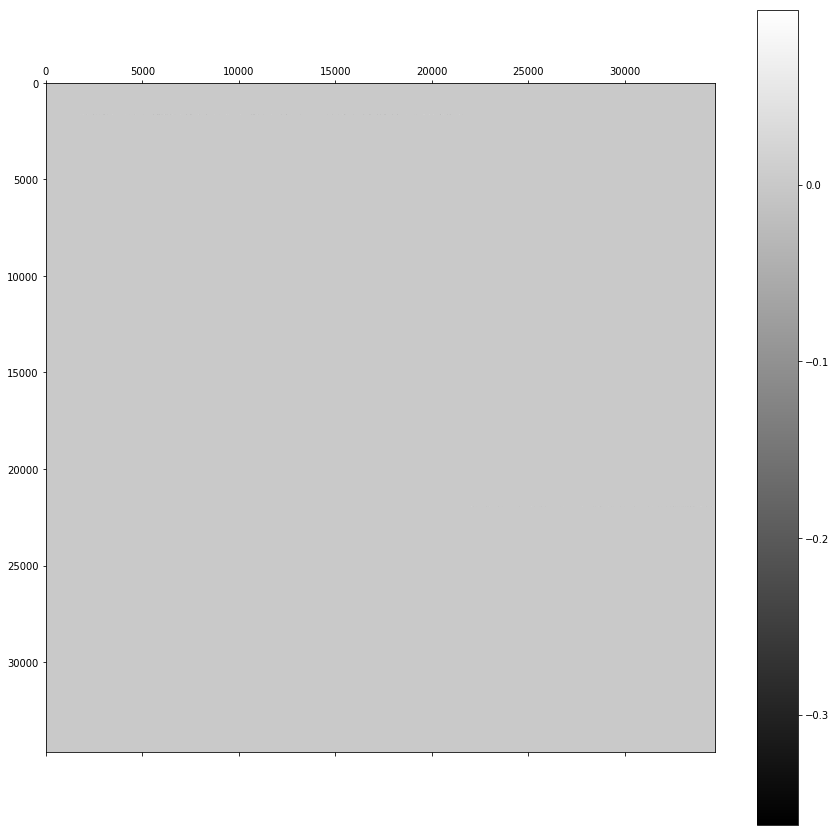

In [27]:
matrix_heatmap(csr_un.toarray())

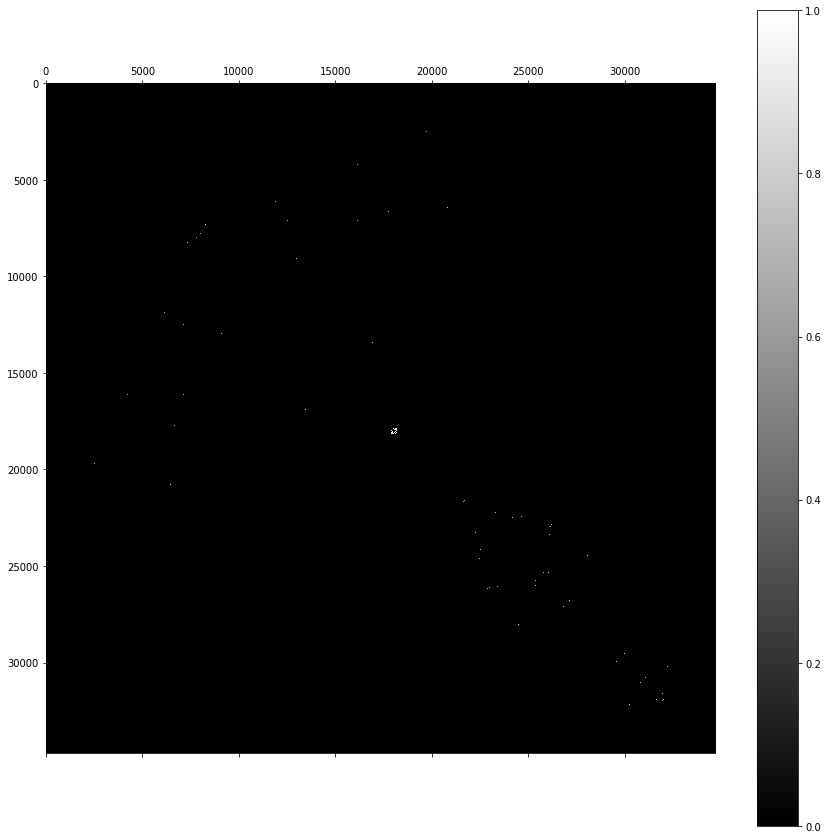

In [32]:
matrix_heatmap(csr_u.toarray())

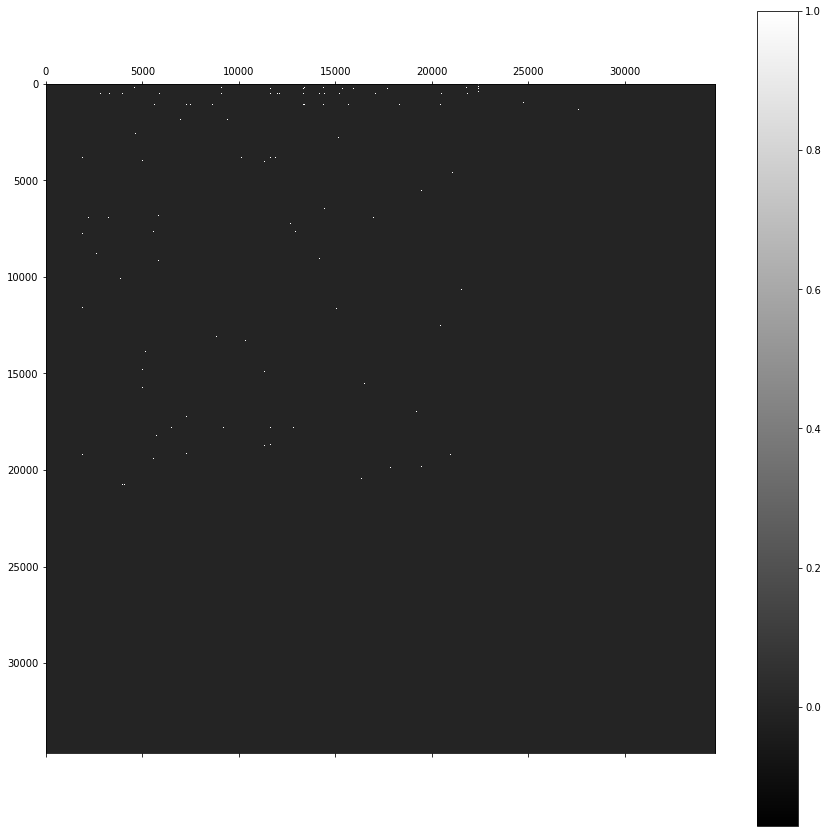

In [33]:
matrix_heatmap(csr_d.toarray())